<a href="https://colab.research.google.com/github/alucinationx/Cripto_Modelling/blob/main/modelolstmteste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -r requirements.txt

In [3]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [4]:
#Variables

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
target_col = 'close'

In [5]:
def get_cripto_price(coin1, coin2, limit):
    '''
    Download data from the cryptocompare api

    Keyword Arguments:\t
    coin1: Coin to compare price to coin 2\t
    coin2: Coin to compare price to coin 1\t
    limit: Limit of values returned. Maximum of 2000.
    '''  
    endpoint = 'https://min-api.cryptocompare.com/data/histoday'
    res = requests.get(endpoint + '?fsym=' + coin1 + '&tsym=' + coin2 + '&limit=' + limit)
    hist = pd.DataFrame(json.loads(res.content)['Data'])
    hist = hist.set_index('time')
    hist.drop(columns=['conversionType', 'conversionSymbol'], inplace=True ,axis=1)
    hist.index = pd.to_datetime(hist.index, unit='s')
    pair = coin1 + '-' + coin2
    return hist, pair

In [6]:
hist, pair = get_cripto_price('ADA','USD','500')
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-02-02,0.05871,0.05492,0.05612,8531715.80,489070.90,0.05578
2020-02-03,0.05795,0.05533,0.05578,5773863.62,327418.30,0.05704
2020-02-04,0.05770,0.05421,0.05704,7516294.49,419354.46,0.05607
2020-02-05,0.06017,0.05561,0.05607,8986317.02,529425.84,0.05925
2020-02-06,0.06074,0.05824,0.05925,9252886.50,552410.24,0.05999


In [7]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.2)

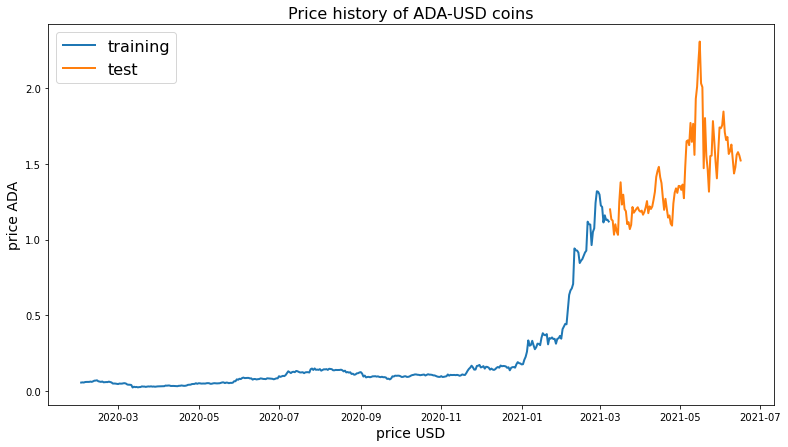

In [23]:
def line_plot(line1, line2, line3=None, label1=None, label2=None, label3=None, pair=pair, lw=2):
    coin1 = pair.split('-')[0]
    coin2 = pair.split('-')[1]
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    if (line3 is not None):
        ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price ' + coin1, fontsize=14)
    ax.set_xlabel('price ' + coin2, fontsize=14)
    ax.set_title('Price history of ' + pair + ' coins', fontsize=16)
    ax.legend(loc='best', fontsize=16)

line_plot(line1=train[target_col], line2=test[target_col], label1='training', label2='test', pair=pair)

In [9]:
def normalise_zero_base(df):
    '''
    Get the first five columns (where we have numbers) and divide by the first row, to normalise dataframe
    '''
    return df / df.iloc[0] - 1

In [10]:
def extract_window_data(df, window_len=7, zero_base=True):
    '''
    Convert dataframe to overlapping sequences/windows of
        length `window`.
    '''
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [11]:
def prepare_data(train_data, test_data, target_col, window_len=10, zero_base=True):
    '''
    Prepare data for LSTM
    '''
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_train = np.asarray(X_train).astype(np.float32) #adjust numpy array for using keras

    X_test = extract_window_data(test_data, window_len, zero_base)
    X_test = np.asarray(X_test).astype(np.float32) #adjust numpy array for using keras
    
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [13]:
train, test, X_train, X_test, y_train, y_test = prepare_data(train_data=train, test_data=test, target_col=target_col, window_len=window_len, zero_base=zero_base)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 19s 5ms/step - loss: 0.0274
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 10/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0073
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0078
Epoch 12/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 13/20
13/13 [=============================

In [14]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

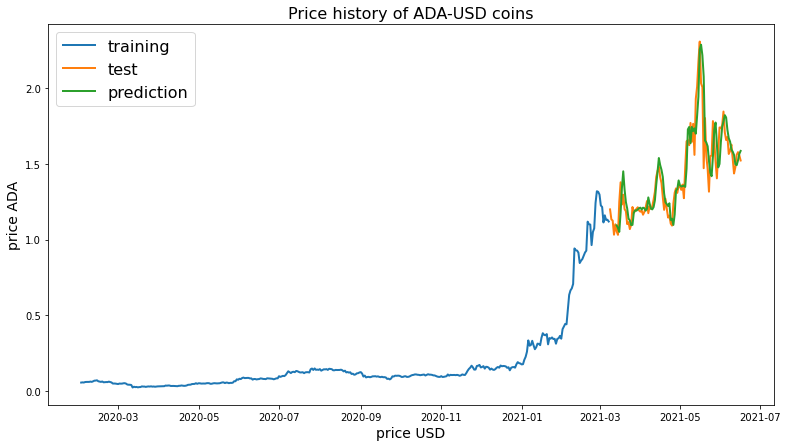

In [24]:
line_plot(line1=train[target_col], line2=test[target_col], line3=preds ,label1='training', label2='test', label3='prediction', pair=pair)

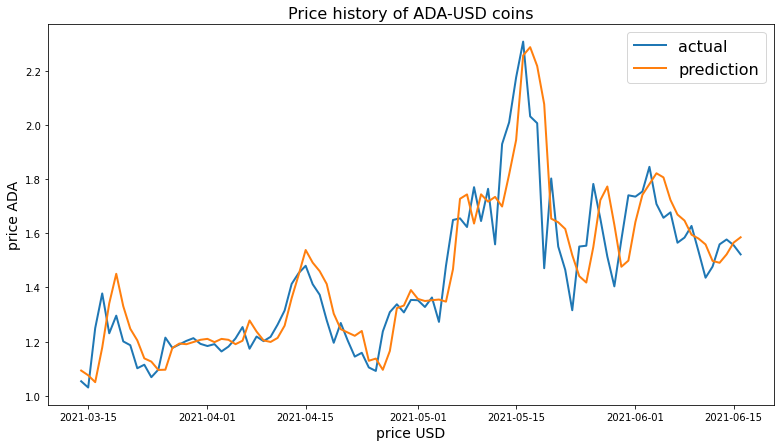

In [25]:
line_plot(line1=targets, line2=preds ,label1='actual', label2='prediction', pair=pair)